# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Titanic - Machine Learning from Disaster (EDA)</p>

<blockquote style="margin-right:auto; margin-left:auto; background-color:#26344e; padding: 15px; border-radius: 10px 10px">
    <b><span style="color:#f2f2f0; font-size:20px; font-family:JetBrains Mono; margin-left: 10px;">
        Competition Description 📜
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        This is the legendary Titanic ML competition – the best, first challenge for you to dive into ML competitions and familiarize yourself with how the Kaggle platform works.
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Task 🕵
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        The competition is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck.
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        See More Here 📈
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        <a href="https://www.kaggle.com/competitions/titanic/overview">Titanic - Machine Learning from Disaster</a>
    </p>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        This Notebook Covers 📔
    </span></b>
    <ul style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono;  margin-left: 10px; margin-right: 15px; margin-top: 15px; margin-bottom: 20px">
        <li>A quick look at the training dataset (which features are available, where we have missing values, etc.).</li>
        <li>Heatmap with correlations, pair plots and KDEs.</li>
        <li>Boxplots by travellers' Age and Fare.</li>
        <li>Probability plots for Age and Fare (whether these attributes derive from the normal distribution).</li>
        <li>Summary tables with Survival/Death Rates:</li>
        <ul style="font-size:16px; color:#f2f2f0; font-family:JetBrains Mono; margin-right: 15px">
            <li>Class & Age vs Survival Rate.</li>
            <li>Sex & Embarked & Pclass vs Survival Rate.</li>
            <li>IsAlone vs Survival Rate.</li>
            <li>Title (e.g. Master) vs Survival Rate.</li>
            <li>Cabin Deck vs Survival Rate.</li>
        </ul>
        <li>Several fancy plots with Plotly (i.e. parallel coordinates plot, pie charts).</li>
        <li>Short insights and notes about what we do at a certain moment.</li>
    </ul>
    <b><span style="color:#f2f2f0;font-size:20px;font-family:JetBrains Mono; margin-left: 10px;">
        Machine Learning Notebook 📊
    </span></b>
    <p style="color:#f2f2f0; font-size:16px;font-family: JetBrains Mono; margin-left: 25px; margin-right: 25px; margin-top: 15px; margin-bottom: 20px">
        In this notebook, I handle exploratory data analysis in general. If you're interested in ML, please see the link below.<br>
        <a href="https://www.kaggle.com/code/mateuszk013/titanic-machine-learning-with-insights">Titanic - Machine Learning with Insights</a>
    </p>
</blockquote>

In [143]:
import os
import shutil
import subprocess
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from IPython.display import display_html
from matplotlib.patches import PathPatch

# Indicates whether the notebook is running on Kaggle or not.
ON_KAGGLE = os.getenv("KAGGLE_KERNEL_RUN_TYPE") is not None
MODELS_PATH = Path("models")
MODELS_PATH.mkdir(exist_ok=True)  # If directory exists, do nothing.

FONT_COLOR = "#141B4D"
BACKGROUND_COLOR = "#F6F5F5"
DF_CMAP = sns.light_palette("#2a357d", as_cmap=True)

MY_RC = {
    "axes.labelcolor": FONT_COLOR,
    "axes.labelsize": 10,
    "axes.labelpad": 15,
    "axes.labelweight": "bold",
    "axes.titlesize": 14,
    "axes.titleweight": "bold",
    "axes.titlepad": 15,
    "xtick.labelsize": 10,
    "xtick.color": FONT_COLOR,
    "ytick.labelsize": 10,
    "ytick.color": FONT_COLOR,
    "figure.titlesize": 14,
    "figure.titleweight": "bold",
    "figure.facecolor": BACKGROUND_COLOR,
    "figure.edgecolor": BACKGROUND_COLOR,
    "figure.dpi": 72,  # Locally Seaborn uses 72, meanwhile Kaggle 96.
    "font.size": 10,
    "font.family": "Serif",
    "text.color": FONT_COLOR,
}

sns.set_theme(rc=MY_RC)


def download_from_kaggle(competition):
    command = "kaggle competitions download -c "
    filepath = Path("data/" + competition + ".zip")

    if not filepath.is_file():
        subprocess.run((command + competition).split())
        Path("data").mkdir(parents=True, exist_ok=True)
        shutil.unpack_archive(competition + ".zip", "data")
        shutil.move(competition + ".zip", "data")


def adjust_box_widths(g, factor, orient="v"):
    """
    Adjust the widths/heights of a seaborn-generated boxplot.
    """
    if orient not in ("v", "h"):
        raise ValueError("The `orient` should be 'v' or 'h'.")

    i = 1
    if orient == "h":
        i = 0

    # iterating through Axes instances
    for ax in g.axes:
        # iterating through axes artists:
        for c in ax.get_children():
            # searching for PathPatches
            if isinstance(c, PathPatch):
                # getting current height/width of box:
                p = c.get_path()
                verts = p.vertices
                verts_sub = verts[:-1]
                min_ = np.min(verts_sub[:, i])
                max_ = np.max(verts_sub[:, i])
                mid_ = 0.5 * (min_ + max_)
                half_ = 0.5 * (max_ - min_)

                # setting new height of box
                min_new_ = mid_ - factor * half_
                max_new_ = mid_ + factor * half_
                verts_sub[verts_sub[:, i] == min_, i] = min_new_
                verts_sub[verts_sub[:, i] == max_, i] = max_new_

                # setting new height/width of median line
                if orient == "v":
                    for l in ax.lines:
                        if len(l.get_ydata()) == 2 and np.all(
                            l.get_ydata() == [min_, max_]
                        ):
                            l.set_ydata([min_new_, max_new_])
                elif orient == "h":
                    for l in ax.lines:
                        if len(l.get_xdata()) == 2 and np.all(
                            l.get_xdata() == [min_, max_]
                        ):
                            l.set_xdata([min_new_, max_new_])


# This patch comes from.
# https://github.com/ageron/handson-ml3/blob/main/02_end_to_end_machine_learning_project.ipynb
def monkey_patch_get_signature_names_out():
    """Monkey patch some classes which did not handle get_feature_names_out()
    correctly in Scikit-Learn 1.0.*."""
    from inspect import Signature, signature, Parameter
    import pandas as pd
    from sklearn.impute import SimpleImputer, KNNImputer
    from sklearn.pipeline import make_pipeline, Pipeline
    from sklearn.preprocessing import FunctionTransformer, StandardScaler

    default_get_feature_names_out = StandardScaler.get_feature_names_out

    if not hasattr(SimpleImputer, "get_feature_names_out"):
        # print("Monkey-patching SimpleImputer.get_feature_names_out()")
        SimpleImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(KNNImputer, "get_feature_names_out"):
        # print("Monkey-patching KNNImputer.get_feature_names_out()")
        KNNImputer.get_feature_names_out = default_get_feature_names_out

    if not hasattr(FunctionTransformer, "get_feature_names_out"):
        # print("Monkey-patching FunctionTransformer.get_feature_names_out()")
        orig_init = FunctionTransformer.__init__
        orig_sig = signature(orig_init)

        def __init__(*args, feature_names_out=None, **kwargs):
            orig_sig.bind(*args, **kwargs)
            orig_init(*args, **kwargs)
            args[0].feature_names_out = feature_names_out

        __init__.__signature__ = Signature(
            list(signature(orig_init).parameters.values())
            + [Parameter("feature_names_out", Parameter.KEYWORD_ONLY)]
        )

        def get_feature_names_out(self, names=None):
            if callable(self.feature_names_out):
                return self.feature_names_out(self, names)
            assert self.feature_names_out == "one-to-one"
            return default_get_feature_names_out(self, names)

        FunctionTransformer.__init__ = __init__
        FunctionTransformer.get_feature_names_out = get_feature_names_out


monkey_patch_get_signature_names_out()


# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Quick Look at Dataset</p>

<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Feature Description 📜</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li><code>Survived</code> - Whether the passenger survived (1) or not (0).</li>
    <li><code>Pclass</code> - Ticket class. A proxy for socio-economic status (SES), i.e. 1st = Upper, 2nd = Middle, 3rd = Lower.</li>
    <li><code>Name</code> - Passenger name.</li>
    <li><code>Sex</code> - Passenger sex.</li>
    <li><code>Age</code> - Passenger age in years.</li>
    <li><code>SibSp</code> - Number of siblings / spouses aboard the Titanic.</li>
    <li><code>Parch</code> - Number of parents / children aboard the Titanic.</li>
    <li><code>Ticket</code> - Ticket number.</li>
    <li><code>Fare</code> - Passenger fare.</li>
    <li><code>Cabin</code> - Cabin number.</li>
    <li><code>Embarked</code> - Port of Embarkation, i.e. C = Cherbourg, Q = Queenstown, S = Southampton.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>We glance at the dataset and see the general information about missing values and categorical and numerical features.</li>
</ul>

In [144]:
competition = "titanic"

if not ON_KAGGLE:
    download_from_kaggle(competition)
    train_path = "data/train.csv"
    test_path = "data/test.csv"
else:
    train_path = f"/kaggle/input/{competition}/train.csv"
    test_path = f"/kaggle/input/{competition}/test.csv"

train = pd.read_csv(train_path, index_col="PassengerId")
test = pd.read_csv(test_path, index_col="PassengerId")


In [145]:
train.head()


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [146]:
train.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [147]:
categorical = train.select_dtypes("object").columns
numerical = train.select_dtypes("number").columns

print("Categorical:".ljust(15), f"{list(categorical)}".ljust(60), len(categorical))
print("Numerical:".ljust(15), f"{list(numerical)}".ljust(60), len(numerical))


Categorical:    ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']               5
Numerical:      ['Survived', 'Pclass', 'Age', 'SibSp', 'Parch', 'Fare']      6


In [148]:
print("Train Dataset NaNs:")
print(train.isna().sum()[train.isna().sum() > 0])
print()
print("Test Dataset NaNs:")
print(test.isna().sum()[test.isna().sum() > 0])


Train Dataset NaNs:
Age         177
Cabin       687
Embarked      2
dtype: int64

Test Dataset NaNs:
Age       86
Fare       1
Cabin    327
dtype: int64


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>The dataset is small. We have here about 900 samples. None of the models should have a problem here.</li>
    <li>We have five categorical features and six numerical including the binary target.</li>
    <li>Four features need imputation. These are <code>Age</code>, <code>Cabin</code>, <code>Embarked</code> and <code>Fare</code>. Moreover, for the <code>Cabin</code> feature, missing values compose about 3/4 of the training set!
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see the general summary of numerical features.</li>
</ul>

In [149]:
train.describe(percentiles=[0.05, 0.25, 0.50, 0.75, 0.95]).T.drop(
    "count", axis=1
).rename(columns=str.title).style.background_gradient(DF_CMAP)


,Mean,Std,Min,5%,25%,50%,75%,95%,Max
Survived,0.383838,0.486592,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000
Pclass,2.308642,0.836071,1.000000,1.000000,2.000000,3.000000,3.000000,3.000000,3.000000
Age,29.699118,14.526497,0.420000,4.000000,20.125000,28.000000,38.000000,56.000000,80.000000
SibSp,0.523008,1.102743,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,8.000000
Parch,0.381594,0.806057,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,6.000000
Fare,32.204208,49.693429,0.000000,7.225000,7.910400,14.454200,31.000000,112.079150,512.329200


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Only 38% of passengers survived.</li>
    <li>Most of the passengers had lower socio-economic status. They travelled within 3rd class.</li>
    <li>Passengers were primarily young (< 30 years old), and 3/4 of them had less than 38 years old.</li>
    <li>We can see through the <code>Fare</code> feature that there were affluent people (max value is enormous compared to Q1-Q3). Nevertheless, most people paid similar fares.
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see the heatmap (hierarchically clustered heatmap) of the dataset. Heatmap hierarchically clustering results, placing similar observations close to each other, additionally, with correlation coefficients for each pair.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Heatmap & Distributions & Boxplots & Groups Survival Rate</p>

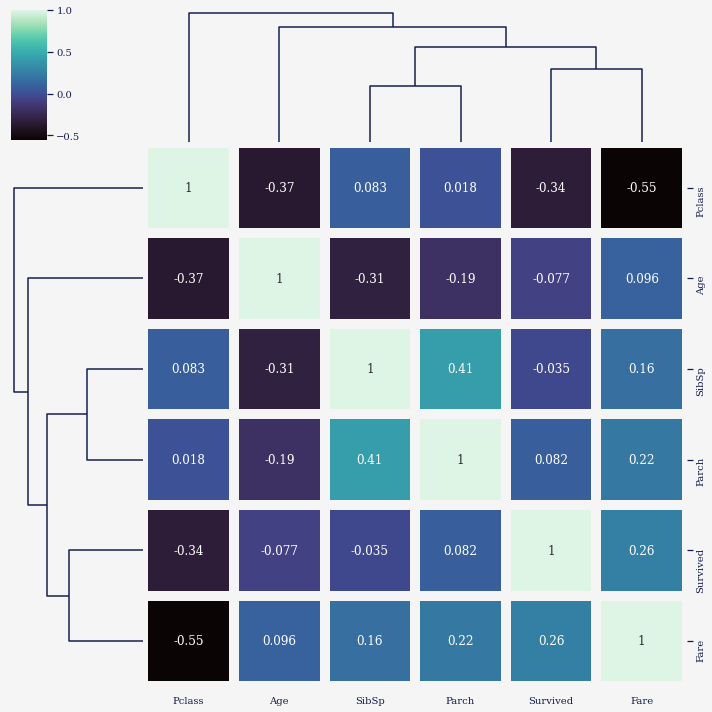

In [150]:
sns.clustermap(
    train.corr(numeric_only=True),
    linecolor=BACKGROUND_COLOR,
    linewidth=10,
    annot=True,
    cmap="mako",
    tree_kws={"linewidths": 1.5, "color": "#141B4D"},
    annot_kws={"fontsize": 12},
    figsize=(10, 10),
)
plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li><code>Pclass</code> and <code>Fare</code> have a relatively strong correlation, which should be obvious when we think about it.</li>
    <li><code>Age</code> vs <code>Pclass</code> and <code>Pclass</code> vs <code>Survived</code> are interesting. Correlations are negative, which also is reasonable. Older passengers usually are more affluent. We can also see that upper-class members were probably more likely to survive.</li>
    <li><code>SibSp</code> and <code>Parch</code> are positively correlated, which could mean families were on the board.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's look at distributions and scatter pair plots for each numerical pair.</li>
</ul>

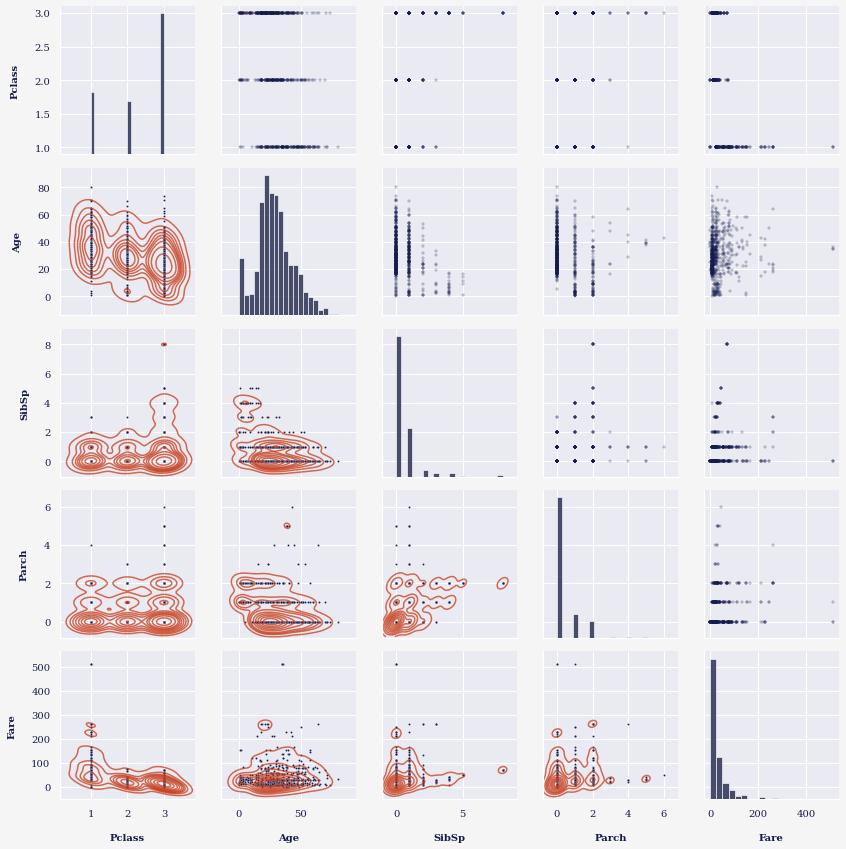

In [151]:
grid = sns.PairGrid(train.drop("Survived", axis=1), diag_sharey=False)

grid.fig.set_facecolor(BACKGROUND_COLOR)
grid.fig.set_size_inches(12, 12)

grid.map_upper(sns.scatterplot, color="#141b4d", marker="+", s=10)
grid.map_diag(sns.histplot, color="#0f173b", bins=20)
grid.map_lower(sns.scatterplot, color="#141b4d", marker="o", s=4)
grid.map_lower(sns.kdeplot, levels=10, color="#c73c1a", alpha=0.75)

plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see at <code>Pclass</code> vs <code>Age</code>. Here actually, more exclusive class, older passengers.</li>
    <li>Let's have a look at <code>Fare</code>. We can easily see this max value, i.e. 512, is an outlier. Fares usually were at most 250. Moreover, that person was travelling with someone, see at <code>Parch</code>.</li>
    <li>Many people travelled alone, insofar as I can see within <code>SibSp</code> and <code>Parch</code>.</li>
    <li>Let's look at <code>Pclass</code> vs <code>Fare</code> KDE. Here, we can see a small spread of fare for the lower class (3), whereas values have a wide range for the upper class (1).</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Now we'll make something similar but with survived/not survived groups.</li>
</ul>

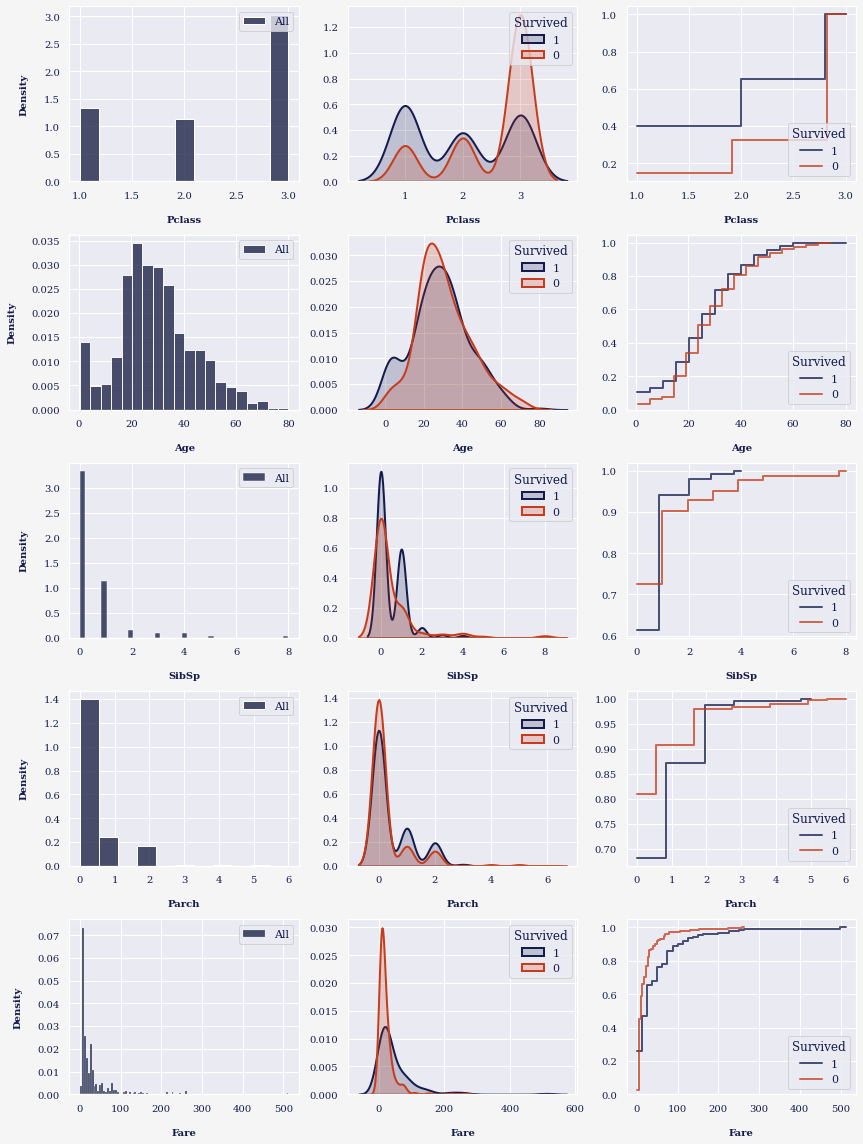

In [152]:
survived_mask = train["Survived"] == 1
features = ["Pclass", "Age", "SibSp", "Parch", "Fare"]

fig, axes = plt.subplots(nrows=5, ncols=3, figsize=(12, 16), tight_layout=True)
kde_kw = dict(fill=True, linewidth=2, alpha=0.2)
hist_kw = dict(
    linewidth=2, alpha=0.75, element="step", fill=False, cumulative=True, stat="density"
)

for feature, ax in zip(features, axes):
    full = train[feature]
    survived = train.loc[survived_mask, feature]
    non_survived = train.loc[~survived_mask, feature]

    plt.sca(ax[0])
    sns.histplot(x=full, color="#0f173b", stat="density", label="All", alpha=0.75)
    plt.legend(loc="upper right")

    plt.sca(ax[1])
    sns.kdeplot(x=survived, color="#141b4d", label="1", **kde_kw)
    sns.kdeplot(x=non_survived, color="#c73c1a", label="0", **kde_kw)
    plt.ylabel("")
    plt.legend(loc="upper right", title="Survived")

    plt.sca(ax[2])

    sns.histplot(x=survived, color="#141b4d", label="1", **hist_kw)
    sns.histplot(x=non_survived, color="#c73c1a", label="0", **hist_kw)
    plt.legend(loc="lower right", title="Survived")
    plt.ylabel("")

plt.show()


In [153]:
names = {
    "mean": "MeanSurvivalRate",
    "sum": "Survivors",
    "count": "GroupSize",
}

df1 = (
    train.pivot_table(
        values="Survived",
        index=("Pclass", pd.qcut(train["Age"], 5)),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=names,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .set_table_attributes("style='display:inline'")
)

df2 = (
    train.pivot_table(
        values="Survived",
        index="Pclass",
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name="Total",
    )
    .rename(
        columns=names,
    )
    .droplevel(level=1, axis="columns")
    .style.background_gradient(DF_CMAP)
    .set_table_attributes("style='display:inline'")
)

display_html(df1._repr_html_() + df2._repr_html_(), raw=True)


MeanSurvivalRate 
 Survivors 
 GroupSize 
 
 
 Pclass 
 Age 
   
   
   
 
 
 
 
 1 
 (0.419, 19.0] 
 0.809524 
 17 
 21 
 
 
 (19.0, 25.0] 
 0.761905 
 16 
 21 
 
 
 (25.0, 31.8] 
 0.666667 
 16 
 24 
 
 
 (31.8, 41.0] 
 0.777778 
 35 
 45 
 
 
 (41.0, 80.0] 
 0.506667 
 38 
 75 
 
 
 2 
 (0.419, 19.0] 
 0.742857 
 26 
 35 
 
 
 (19.0, 25.0] 
 0.400000 
 12 
 30 
 
 
 (25.0, 31.8] 
 0.416667 
 15 
 36 
 
 
 (31.8, 41.0] 
 0.461538 
 18 
 39 
 
 
 (41.0, 80.0] 
 0.363636 
 12 
 33 
 
 
 3 
 (0.419, 19.0] 
 0.333333 
 36 
 108 
 
 
 (19.0, 25.0] 
 0.197674 
 17 
 86 
 
 
 (25.0, 31.8] 
 0.283582 
 19 
 67 
 
 
 (31.8, 41.0] 
 0.166667 
 10 
 60 
 
 
 (41.0, 80.0] 
 0.088235 
 3 
 34 
 
 
 Total 
 
 0.383838 
 342 
 891 
 
 
 

 
 
 
   
 MeanSurvivalRate 
 Survivors 
 GroupSize 
 
 
 Pclass 
   
   
   
 
 
 
 
 1 
 0.629630 
 136 
 216 
 
 
 2 
 0.472826 
 87 
 184 
 
 
 3 
 0.242363 
 119 
 491 
 
 
 Total 
 0.383838 
 342 
 891

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's look at <code>Pclass</code> again (as you can see, this feature is so interesting). Here we have a significant difference between the upper and lower classes for passengers who survived and died. Around 63% of passengers in the 1st class survived, whereas only 24% from the 3rd one. In the 2nd class, the issue is around 50/50.</li>
    <li>The second important observation is related to <code>Age</code> obviously. We can easily see that they tried to save children and teenagers first. Again, the more exclusive class children belonged to, the higher chance to survive.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>In order to better understand <code>Age</code>, <code>Class</code> and <code>Fare</code> relations, we will draw boxplots of these features.</li>
</ul>

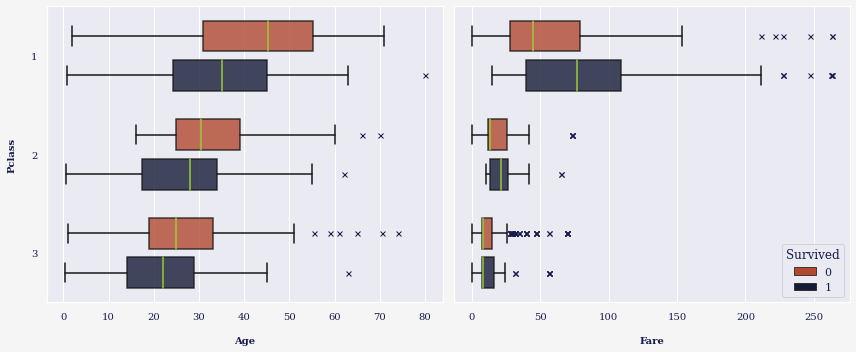

In [154]:
df = train.copy()
df.loc[df["Fare"] > 500, "Fare"] = df["Fare"].median()
df[["Survived", "Sex", "Pclass"]] = df[["Survived", "Sex", "Pclass"]].astype("category")

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), tight_layout=True)

palette = {0: "#c73c1a", 1: "#0f173b"}
medianprops = {"color": "yellowgreen", "alpha": 1}
flierprops = {"marker": "x", "mec": "#141b4d", "mfc": "#141b4d"}
kw = {"medianprops": medianprops, "flierprops": flierprops, "palette": palette}

sns.boxplot(data=df, x="Age", y="Pclass", hue="Survived", ax=ax1, **kw)
sns.boxplot(data=df, x="Fare", y="Pclass", hue="Survived", ax=ax2, **kw)

for patch in np.r_[ax1.patches, ax2.patches]:
    col = patch.get_facecolor()
    patch.set_alpha(0.8)

ax1.legend("", frameon=False)
ax2.set_ylabel("")
ax2.set_yticks([])

adjust_box_widths(fig, 0.8, "v")
plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Important! I dropped the highest fare because the boxplots were unreadable.</li>
    <li>There we have the confirmation of what we could see before regarding <code>Pclass</code> vs <code>Age</code> and <code>Pclass</code> vs <code>Fare</code> relations.</li>
    <li>Passengers travelling by 1st class are responsible for the long tail in the <code>Fare</code> distribution.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's stay with <code>Age</code> and <code>Fare</code> and create probability plots. Such a visualisation tells us whether these variables come from the normal distribution.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Probability Plots</p>

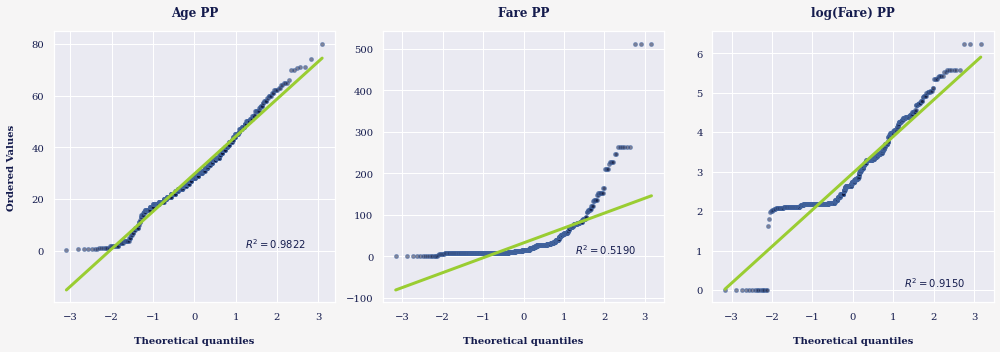

In [155]:
from scipy.stats import probplot

# Probplot requires non-nan values.
df = train.copy().dropna(subset=["Age"])

fig, (ax1, ax2, ax3) = plt.subplots(
    nrows=1, ncols=3, figsize=(14, 5), tight_layout=True
)

probplot(df["Age"], plot=ax1, rvalue=True)
plt.sca(ax1)
plt.title("Age PP", fontsize=12)

probplot(train["Fare"], plot=ax2, rvalue=True)
plt.sca(ax2)
plt.ylabel("")
plt.title("Fare PP", fontsize=12)

probplot(np.log1p(train["Fare"]), plot=ax3, rvalue=True)
plt.sca(ax3)
plt.ylabel("")
plt.title("log(Fare) PP", fontsize=12)

for ax in (ax1, ax2, ax3):
    ax.get_lines()[0].set_markerfacecolor("#0f173b")
    ax.get_lines()[0].set_markersize(4.0)
    ax.get_lines()[0].set_alpha(0.5)
    ax.get_lines()[1].set_linewidth(3.0)
    ax.get_lines()[1].set_color("yellowgreen")

plt.show()

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As you can see, age almost perfectly fits a normal distribution, which manifests by a high coefficient of determination (R-squared) and evenly deployed samples around the green line.</li>
    <li>On the other hand, the situation with <code>Fare</code> is rather mediocre, however, we may fix this pretty well with log-level transformation.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>We can glance at the <code>Age</code> vs <code>Fare</code> bubble plot yet.</li>
</ul> 

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Fancy Plots with Plotly & Groups Survival Rate</p>

In [156]:
df["SqrtFare"] = np.sqrt(df["Fare"])

fig = px.scatter(
    data_frame=df,
    x="Age",
    y="Fare",
    log_y=True,
    size="Fare",
    color="SqrtFare",
    color_continuous_scale="PuOr",
    facet_col="Pclass",
    category_orders={"Pclass": (3, 2, 1)},
    hover_name="Name",
    height=500,
    width=800,
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    coloraxis_showscale=False,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As you may see, the 2nd and 3rd classes are not so different. Nevertheless, it's easy to observe that children travellers decrease regarding the more exclusive class. For example, in 1st class, we have only several (around 20 as far as I remember) children and teenagers.</li>
    <li>Also, it's easy to see threshold fare values for each class. In the 3rd class, it's around 6.5, the 2nd about 10.5, and the 1st about 26.0.</li>
    <li>Nevertheless, there are traveller outsiders. For example, in the 1st class, one person travelled for 5 pounds.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's see, I think, the most relevant relation, i.e. <code>Sex</code> vs <code>Survived</code>.</li>
</ul> 

In [157]:
df = train.copy()
df["Sex"] = df["Sex"].str.title()

df.groupby("Sex", group_keys=False).apply(
    lambda sex: sex.pivot_table(
        values="Survived",
        index=("Sex", "Embarked", "Pclass"),
        aggfunc=["mean", "sum", "count"],
        margins=True,
        margins_name=f"{sex.name} Total",
    )
    .rename(
        columns=names,
    )
    .droplevel(level=1, axis="columns")
).style.background_gradient(DF_CMAP)


In [158]:
df = train.copy()
df["Survived"] = df["Survived"].map({1: "Survived", 0: "Died"})
df["Sex"] = df["Sex"].map({"male": "Male", "female": "Female"})

fig = px.sunburst(
    data_frame=df,
    title="Passengers Onboard",
    path=["Sex", "Survived"],
    color_discrete_sequence=["#0f173b", "#c73c1a"],
    height=500,
    width=800,
)
fig.update_traces(textinfo="label+percent parent", insidetextorientation="horizontal")
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>And there we have a vast difference. See that almost the entire block in data frame for women is blue, whereas for man is practically white. Nearly all women who travelled by 1st class survived! Slightly worse the situation looks in 3rd class, but still, it's not comparable with men in general.</li>
    <li>About 74% of women survived the disaster.</li>
    <li>Only 19% of men survived the disaster.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>It's good to see all this stuff for people who travelled alone or with somebody.</li>
</ul>

In [159]:
df = train.copy()
df["IsAlone"] = df.eval("SibSp + Parch") == 0

df.pivot_table(
    values="Survived",
    index="IsAlone",
    aggfunc=["mean", "sum", "count"],
    margins=True,
    margins_name="Total",
).rename(columns=names,).droplevel(level=1, axis="columns").style.background_gradient(
    DF_CMAP
)


,MeanSurvivalRate,Survivors,GroupSize
IsAlone,,,
False,0.505650,179,354
True,0.303538,163,537
Total,0.383838,342,891


In [160]:
df["Survived"] = df["Survived"].map({1: "Survived", 0: "Died"})
df["IsAlone"] = df["IsAlone"].map({True: "Alone", False: "NotAlone"})

fig = px.sunburst(
    data_frame=df,
    title="Alone Passengers Onboard",
    path=["IsAlone", "Survived"],
    color_discrete_sequence=["#0f173b", "#c73c1a"],
    height=500,
    width=800,
)
fig.update_traces(textinfo="label+percent parent", insidetextorientation="horizontal")
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Alone passengers have not had it easy. We can see 70% of them died in the disaster.</li>
    <li>On the other hand, if somebody had a relative onboard, it means he/she had a 50/50 chance to survive.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Let's create the parallel coordinates plot. This type of visualisation is super helpful in multivariate analysis to see relationships between numerical variables. On parallel coordinates plot, each variable has given an axis; meanwhile, axes are deployed in a parallel manner. Therefore, we can plot lines between them.</li>
    <li>I decided to include the <code>IsAlone</code> feature instead of <code>SibSp</code> and <code>Parch</code>.</li>
</ul>

In [161]:
df = train.copy()
df["IsAlone"] = (df.eval("SibSp + Parch") == 0).astype(int)

fig = px.parallel_coordinates(
    data_frame=df,
    color="Survived",
    dimensions=["IsAlone", "Age", "Pclass", "Fare", "Survived"],
    color_continuous_scale=px.colors.diverging.PuOr,
    height=500,
    width=800,
)
fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
    coloraxis_colorbar=dict(
        orientation="h",
        title_side="bottom",
        yanchor="bottom",
        xanchor="center",
        y=-0.35,
        x=0.5,
    ),
)

fig.show()


c:\Programy\Python\Python310\lib\site-packages\plotly\express\_core.py:279: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



In [162]:
train.query("Fare > 500 | Age == 80")


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,NaN,C
631,1,1,"Barkworth, Mr. Algernon Henry Wilson",male,80.0,0,0,27042,30.0000,A23,S
680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>At first, sight is a little messy here but see for example on that person who was 80 years old and travelled alone in the 1st class. Here it's immediately visible, whereas it's not on other types of plots.</li>
    <li>Also, the highest fare instance is an eye-catcher.</li>
    <li>Curiosity: Miss. Anna Ward was a personal maid to Mrs Charlotte Wardle Cardeza. Charlotte was traveling with her maid (Anna), valet (Gustave), and 36-year-old son (Thomas), who all survived.</li>
    <li>There needs to be clarity with Algernon Henry Barkworth. He was 47 years old. He was 80 when he died. See here: <a href="https://www.encyclopedia-titanica.org/titanic-survivor/algernon-barkworth.html">Algernon Henry Barkworth</a>.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>Since we dispose of passenger names, we can extract their titles to indulge in the general status of the passenger. We again contrast this information with <code>Survived</code>. For example, maybe married women had a higher chance of surviving.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Handling Titles & Cabin Deck</p>

In [163]:
df = train.copy()
df["Title"] = df["Name"].str.extract(r" ([A-Za-z]+)\.")
unique_titles = np.setdiff1d(df["Title"], ["Mr", "Miss", "Mrs", "Master"]).tolist()
df["Title"] = df["Title"].replace(unique_titles, "Other")

titles_info = (
    pd.crosstab(
        df["Title"],
        df["Survived"],
        normalize="index",
    )
    .join(df["Title"].value_counts())
    .rename(
        columns={
            0: "DeathRate",
            1: "SurvivalRate",
            "Title": "GroupSize",
        }
    )
)

titles_info.style.background_gradient(DF_CMAP)


,DeathRate,SurvivalRate,GroupSize
Title,,,
Master,0.425000,0.575000,40
Miss,0.302198,0.697802,182
Mr,0.843327,0.156673,517
Mrs,0.208000,0.792000,125
Other,0.555556,0.444444,27


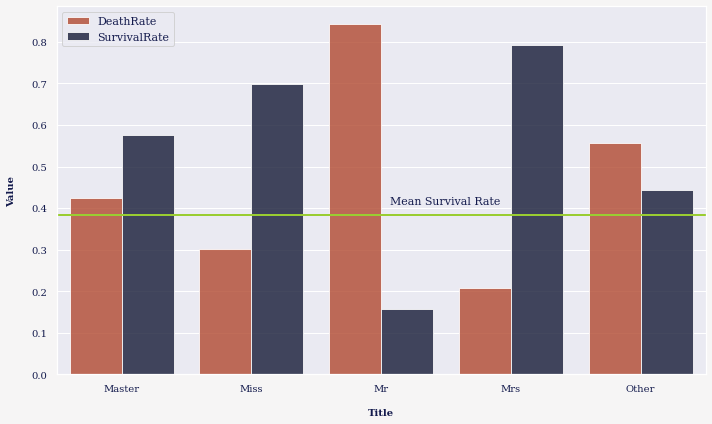

In [164]:
melted = titles_info.reset_index().melt(
    id_vars="Title",
    value_vars=["DeathRate", "SurvivalRate"],
    var_name="Rate",
    value_name="Value",
)

plt.figure(figsize=(10, 6), tight_layout=True)
palette = {"DeathRate": "#c73c1a", "SurvivalRate": "#0f173b"}
sns.barplot(data=melted, x="Title", y="Value", hue="Rate", palette=palette, alpha=0.8)
plt.axhline(df["Survived"].mean(), linewidth=2, color="yellowgreen")
plt.text(2.07, 0.41, "Mean Survival Rate", fontsize=11)
plt.legend(loc="upper left")
plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>See <code>Mrs</code> and <code>Mr</code>. It looks like somebody swapped colours!</li>
    <li>Married women had a high chance to survive. Nevertheless, non-married women too.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>I think one of last elements to analyse is the <code>Cabin</code> issue, so let's look at this.</li>
</ul>

In [165]:
df = train.copy()
df["Cabin"] = df["Cabin"].str[0]

df.pivot_table(
    values="Survived",
    index=["Cabin", "Pclass"],
    aggfunc=["mean", "sum", "count"],
    margins=True,
    margins_name="Total",
).rename(columns=names).droplevel(level=1, axis="columns").style.background_gradient(
    DF_CMAP
)


In [166]:
df.query("Cabin == 'T'")


,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
340,0,1,"Blackwell, Mr. Stephen Weart",male,45.0,0,0,113784,35.5,T,S


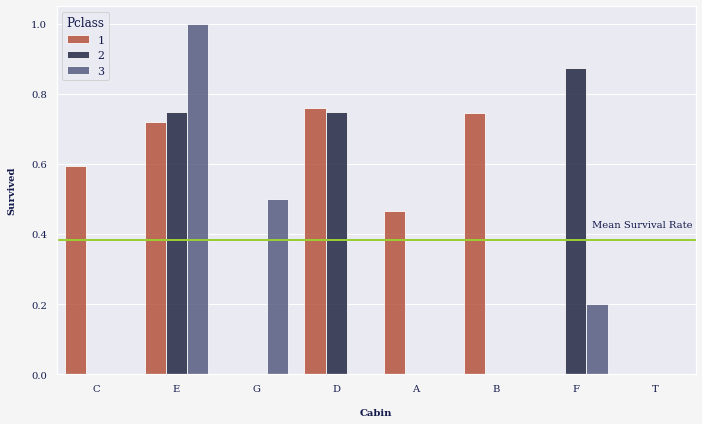

In [167]:
plt.figure(figsize=(10, 6), tight_layout=True)
palette = {1: "#c73c1a", 2: "#0f173b", 3: "#454d82"}
sns.barplot(data=df, x="Cabin", y="Survived", hue="Pclass", alpha=0.8, ci=None, palette=palette)
plt.axhline(df["Survived"].mean(), linewidth=2, color="yellowgreen")
plt.text(6.20, 0.42, "Mean Survival Rate")
plt.legend(loc="upper left", title="Pclass")
plt.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>Okay, so as you can see, <code>A</code>, <code>B</code> and <code>C</code> cabins were attached to the 1st class. For other cabins, the situation is mixed. However, in the test set, the 1st class is not only attached to A, B, and C.</li>
    <li>A puzzling cabin <code>T</code> was attached to only one passenger. This deviates from the lexicographical order of other cabins. As you can notice, we have A, B, C, D, etc.</li>
    <li>It's also wondering that it survived about 67% of passengers with filled cabin attribute. This is probably a coincidence.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>I think the last thing we can do is dimensionality reduction to see how classes look in 3D.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">3D Projection with t-SNE</p>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>TSNE is a valuable tool for visualising high-dimensional data, which helps to conclude whether classes are easily separable.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>To make a 3D plot, we have to prepare a training dataset. In this case, we don't need to be super accurate, and we can simply fill in missing values with the median and most frequent strategies. We also scale and encode attributes.</li>
</ul>

In [168]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.manifold import TSNE


tsne_preprocess = make_column_transformer(
    (
        make_pipeline(SimpleImputer(strategy="median"), StandardScaler()),
        ["Age"],
    ),
    (
        make_pipeline(
            SimpleImputer(strategy="median"),
            FunctionTransformer(func=np.log1p, inverse_func=np.expm1),
            StandardScaler(),
        ),
        ["Fare"],
    ),
    (
        make_pipeline(SimpleImputer(strategy="most_frequent"), OrdinalEncoder()),
        ["Pclass", "Sex", "Embarked", "IsAlone"],
    ),
    remainder="drop",
)

df = train.copy()
df["IsAlone"] = df.eval("SibSp + Parch == 0")
labels = train["Survived"].astype("category")

tsne = TSNE(n_components=3, random_state=42)
X_3d = tsne.fit_transform(tsne_preprocess.fit_transform(df))
X_3d = pd.DataFrame(X_3d, columns=["x1", "x2", "x3"], index=labels.index).join(labels)
X_3d.head()


,x1,x2,x3,Survived
PassengerId,,,,
1,-6.790534,-5.579925,-1.292992,0
2,10.453622,0.112417,5.057104,1
3,-8.081683,-0.127755,5.887538,1
4,8.922507,-1.792780,-3.436335,1
5,-3.929063,10.164669,-0.584738,0


In [171]:
fig = px.scatter_3d(
    data_frame=X_3d,
    x="x1",
    y="x2",
    z="x3",
    symbol="Survived",
    symbol_sequence=["circle", "diamond"],
    color="Survived",
    color_discrete_sequence=["#c73c1a", "#0f173b"],
    opacity=0.5,
    height=700,
    width=800,
    title="Titanic Survivors - 3D projection with t-SNE",
)

fig.update_layout(
    plot_bgcolor=BACKGROUND_COLOR,
    paper_bgcolor=BACKGROUND_COLOR,
)

fig.update_traces(marker_size=4)
fig.show()


<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>As you can see, samples are not easily separable in 3D. We may spot small clusters in various areas, but classes are generally mixed and overlapped.</li>
</ul>
<p style="font-size:20px; font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Next Steps 🕵</p>
<ul style="font-size:16px; font-family:JetBrains Mono; margin-right: 10px;">
    <li>It's time to summarise all this stuff.</li>
</ul>

# <p style="padding:15px; background-color:#26344e; font-family:JetBrains Mono; font-weight:bold; color:#f2f2f0; font-size:100%; letter-spacing: 2px; text-align:center; border-radius: 10px 10px">Exploratory Data Analysis Summary</p>

<blockquote style="margin-right:auto; margin-left:auto; background-color:#26344e; padding: 20px; border-radius: 10px 10px">
    <b><span style="color:#f2f2f0; font-size:20px; font-family:JetBrains Mono; margin-left: 10px;">
        Exploratory Data Analysis Summary 📜
    </span></b>
    <ul style="font-size:16px; color:#f2f2f0; font-family:JetBrains Mono; margin-right: 15px">
        <li>The training dataset is small, composed of about 900 samples. None of the machine learning models should have performance problems here.</li>
        <li>There are five categorical and six numerical attributes, including the binary target (survived, died).</li>
        <li>The following features need imputation: <b>Age</b>, <b>Cabin</b>, <b>Embarked</b> and <b>Fare</b>. In my opinion, we have three possible solutions here:</li>
        <ul style="font-size:16px; color:#f2f2f0; font-family:JetBrains Mono; margin-right: 15px;">
            <li>The most common approach, i.e. fill in with the median and most frequent strategy.</li>
            <li>Group samples and fill in missing values with the representative value from each group.</li>
            <li>Use <b>k-Nearest Neighbors</b> to handle that.</li>
        </ul>
        <li>Only 38% of passengers survived the disaster, so the accuracy metric is appropriate for this problem.</li>
        <li><b>Pclass</b> and <b>Fare</b> are negatively correlated, which is obvious (the correlation coefficient is $-0.55$).
        <li>As a rule, older passengers travelled by more exclusive class.</li>
        <li>The fare distribution for 1st class is a wide range distribution. Fares in this class were so different.</li>
        <li>Passengers from 1st class had a higher chance to survive, whereas those from 3rd one mostly died.</li>
        <li>Children and teenagers had a higher chance to survive, especially those from the 1st class.</li>
        <li><b>Age</b> distribution fits the normal one. The R-squared coefficient equals around $0.98$ here. After log-level transformation for <b>Fare</b>, the R-squared equals around $0.91$. Therefore, we can use scaling for <b>Age</b> and log-level transform for <b>Fare</b>.</li>
        <li>Survival rate is as follows:</li>
        <ul style="font-size:16px; color:#f2f2f0; font-family:JetBrains Mono; margin-right: 15px;">
            <li>In terms of gender, women had a higher survival rate of 74% compared to men who had a survival rate of 19%.</li>
            <li>When it comes to travelling alone, passengers who were not alone had a significantly higher survival rate of 51%, while only 30% of passengers who were travelling alone survived.</li>
        </ul>
    </ul>
    <b><span style="font-size:20px; color:#f2f2f0; font-family:JetBrains Mono; margin-left: 15px;">
        Strategy 📈
    </span></b>
    <ul style="font-size:16px; color:#f2f2f0; font-family:JetBrains Mono; margin-right: 15px">
        <li><b>Pclass</b> - leave as it is or encode with <b>OneHotEncoding</b>.</li>
        <li><b>Name</b> - extract titles and encode them with <b>OneHotEncoding</b>.</li>
        <li><b>Sex</b> - encode with <b>OneHotEncoding</b>.</li>
        <li><b>Age</b> - impute missing values with <b>k-Nearest Neighbors</b> or individual groups median, and use <b>StandardScaler</b>.</li>
        <li><b>SibSp</b> and <b>Parch</b> - merge into one and create binary attribute - <b>IsAlone</b>, then encode with <b>OneHotEncoding</b>.</li>
        <li><b>Ticket</b> - probably this attribute should be dropped.</li>
        <li><b>Fare</b> - fill in missing values within the median and use log-level transformation and then <b>StandardScaler</b>.</li>
        <li><b>Cabin</b> - take only the first letter and try to impute missing values with <b>k-Nearest Neighbors</b>, then encode with <b>OneHotEncoding</b>. Alternatively, drop this attribute since we have 3/4 of the missing values.</li>
        <li><b>Embarked</b> - fill in the missing values with the most frequent one and encode with <b>OneHotEncoding</b>.</li>
    </ul>
</blockquote>

<p style="font-size:20px;font-family:JetBrains Mono; border-bottom: 3px solid #26344e">Notes 📜</p>
<ul style="font-size:16px;font-family:JetBrains Mono; margin-right: 10px;">
    <li>If you read this, thank you.</li>
</ul>